<a href="https://colab.research.google.com/github/denistoo749/LLM-Detect-AI-Generated-Text/blob/main/LLM_Detect_AI_Generated_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM - Detect AI Generated Text
- Machine learning model that can accurately detect whether an essay was written by a student or an LLM.
- Identify which essay was written by a large language model.
- Dataset comprises a mix of student-written essays and essays generated by a variety of LLMs

In [1]:
# Unzip the zipped file
!unzip '/content/drive/MyDrive/LLM - Detect AI Generated Text/llm-detect-ai-generated-text.zip' -d '/content/drive/MyDrive/LLM - Detect AI Generated Text/data/'

Archive:  /content/drive/MyDrive/LLM - Detect AI Generated Text/llm-detect-ai-generated-text.zip
  inflating: /content/drive/MyDrive/LLM - Detect AI Generated Text/data/sample_submission.csv  
  inflating: /content/drive/MyDrive/LLM - Detect AI Generated Text/data/test_essays.csv  
  inflating: /content/drive/MyDrive/LLM - Detect AI Generated Text/data/train_essays.csv  
  inflating: /content/drive/MyDrive/LLM - Detect AI Generated Text/data/train_prompts.csv  


In [2]:
# Import necessary tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# model from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
df = pd.read_csv('/content/drive/MyDrive/LLM - Detect AI Generated Text/data/train_essays.csv')
df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [4]:
df.generated.unique()

array([0, 1])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [6]:
df.isna().sum()

id           0
prompt_id    0
text         0
generated    0
dtype: int64

In [7]:
df['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [8]:
df.describe()

,prompt_id,generated
count,1378.000000,1378.000000
mean,0.486212,0.002177
std,0.499991,0.046625
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [9]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    # This will turn all the string value into category values
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype('category').cat.as_ordered()

    # Turn categorical variables into numbers and fill missing
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes+1

    return df

In [10]:
# Process the test data
df = preprocess_data(df)
df.head()

,id,prompt_id,text,generated
0,1,0,240,0
1,2,0,1265,0
2,3,0,13,0
3,4,0,653,0
4,5,0,165,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         1378 non-null   int16
 1   prompt_id  1378 non-null   int64
 2   text       1378 non-null   int16
 3   generated  1378 non-null   int64
dtypes: int16(2), int64(2)
memory usage: 27.0 KB


In [12]:
df.head()

,id,prompt_id,text,generated
0,1,0,240,0
1,2,0,1265,0
2,3,0,13,0
3,4,0,653,0
4,5,0,165,0


In [13]:
df.describe()

,id,prompt_id,text,generated
count,1378.000000,1378.000000,1378.000000,1378.000000
mean,689.500000,0.486212,689.500000,0.002177
std,397.938647,0.499991,397.938647,0.046625
min,1.000000,0.000000,1.000000,0.000000
25%,345.250000,0.000000,345.250000,0.000000
50%,689.500000,0.000000,689.500000,0.000000
75%,1033.750000,1.000000,1033.750000,0.000000
max,1378.000000,1.000000,1378.000000,1.000000


In [14]:
# Split data into x and y
x = df.drop('generated', axis=1)
y = df['generated']

In [15]:
np.random.seed(42)

# Split the data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)

In [16]:
y_val.value_counts(), y_train.value_counts()

(generated
 0    275
 1      1
 Name: count, dtype: int64,
 generated
 0    1100
 1       2
 Name: count, dtype: int64)

In [17]:
# Resample Minority Class using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [18]:
# Put models into a dictionary
models = {'Logistic Regression': LogisticRegression(),
         'Random Forest': RandomForestClassifier(class_weight='balanced')}

# Create a fuction to fit and score models
def fit_and_score(models, x_train, x_val, y_train, y_val):
    """
    Fit and evaluates given machine learning models.
    models: a dict of different Scikit-learn machine learning models
    x_train: training data (no labels)
    x_test: testing data (no labels)
    y_train: training labels
    y_test: test labels
    """

    # Set random seeds
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores ={}
    # Loop through the models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_resampled, y_resampled)
        # Evaluate the models and append its score to model_scores
        model_scores[name] = model.score(x_val, y_val)

    return model_scores

In [19]:
model_scores = fit_and_score(models=models,
                             x_train=x_train,
                              x_val=x_val,
                              y_train=y_train,
                              y_val=y_val)
model_scores

{'Logistic Regression': 0.8586956521739131,
 'Random Forest': 0.9927536231884058}

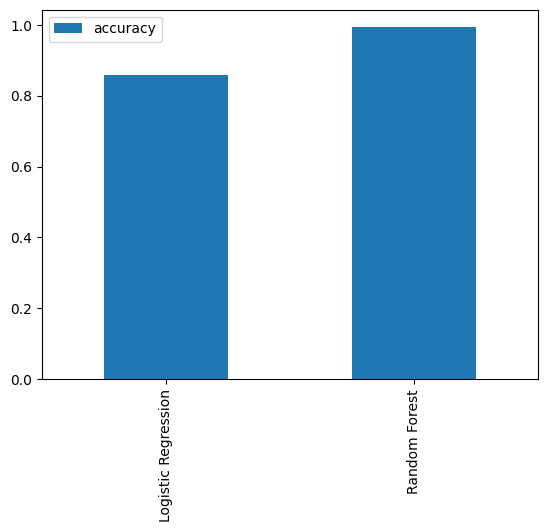

In [20]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

In [21]:
n = np.arange(10, 1000, 50)
n

array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])

In [22]:
# Setup np.random.seed to 42
np.random.seed(42)

# Different LogisticRegression hyperparameters
log_reg_grid = {'C': np.logspace(-4, 4, 20),
               'solver': ['liblinear']}

# Import RandomizedSearchCV from sklearn's model_selection module
from sklearn.model_selection import RandomizedSearchCV


# Setup an instance of RandomizedSearchCV with a LogisticRegression() estimator,
# our log_reg_grid as the param_distributions, a cv of 5 and n_iter of 5.
rs_log_reg = RandomizedSearchCV(estimator= LogisticRegression(class_weight='balanced'),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=10,
                                verbose=True)

# Fit the instance of RandomizedSearchCV
rs_log_reg.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [23]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 1438.44988828766}

In [24]:
rs_log_reg.score(x_val, y_val)

0.8369565217391305

In [34]:
# Setup np.random.seed to 42
np.random.seed(42)

# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {'n_estimators': np.arange(10, 1000, 50),
          'max_depth': [None, 3, 5, 10],
          'min_samples_split': np.arange(2, 20, 2),
          'min_samples_leaf': np.arange(1, 20, 2)}

# Import RandomizedSearchCV from sklearn's model_selection module
from sklearn.model_selection import RandomizedSearchCV

# Setup random hyperparameters search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                               param_distributions=rf_grid,
                               cv=5,
                               n_iter=20,
                               verbose=True)

# Fit random hyperparameter search model for RandomizedForestClassifier
rs_rf.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [41]:
# Find the best parameters
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

In [42]:
rs_rf.score(x_val, y_val)

0.9891304347826086

In [43]:
df_test = pd.read_csv('/content/drive/MyDrive/LLM - Detect AI Generated Text/data/test_essays.csv')
df_test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [44]:
# Copy the csv file
df_tmp = df_test.copy()
df_tmp

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [45]:
# Process the test data
df_tmp = preprocess_data(df_tmp)
df_tmp.head()

,id,prompt_id,text
0,1,2,1
1,2,3,2
2,3,4,3


In [46]:
# Get the feature names from the trained model
feature_names = x_train.columns

In [47]:
# Select the columns in the test data in the same order as the feature names
x_test = df_tmp[feature_names]

In [49]:
y_preds = rs_rf.predict(x_test)

In [50]:
y_preds

array([0, 0, 0])

In [51]:
# Export submission data
submission = pd.DataFrame({'id': df_test['id'], 'generated': y_preds})
submission.to_csv('/content/drive/MyDrive/LLM - Detect AI Generated Text/data/submission.csv', index=False)

In [52]:
df_submission = pd.read_csv('/content/drive/MyDrive/LLM - Detect AI Generated Text/data/submission.csv')
df_submission

,id,generated
0,0000aaaa,0
1,1111bbbb,0
2,2222cccc,0
